# Toronto Neighborhood Analysis for Renting/Buying a house

# 1) Introduction

## 1.1) Backgroud

Toronto is the provincial capital of Ontario and the most populous city in Canada, with a population of 2,731,571 in 2016. Current to 2016, the Toronto census metropolitan area (CMA), of which the majority is within the Greater Toronto Area (GTA), held a population of 5,928,040, making it Canada's most populous CMA. The city is the anchor of the Golden Horseshoe, an urban agglomeration of 9,245,438 people (as of 2016) surrounding the western end of Lake Ontario. Toronto is an international centre of business, finance, arts, and culture, and is recognized as one of the most multicultural and cosmopolitan cities in the world.

People have travelled through and inhabited the Toronto area, situated on a broad sloping plateau interspersed with rivers, deep ravines, and urban forest, for more than 10,000 years.The diverse population of Toronto reflects its current and historical role as an important destination for immigrants to Canada. As an immigrant, people would like to gather a lot of information about one or more preferred locations before deciding to rent/buy a house  in a new location.

## 1.2) Business Problem


Factors that influence the decision to buy/rent a house in a neighborhood of Toronto include : <br/>
1. Population of Neighborhood <br/>
2. Average house price <br/>
3. Average school rating <br/>
4. Crime rates <br/>
5. Top most common places in neighborhood </br/>

This project focus to help people select the best locality to move in based on features for a neighborhood.This includes a comparison between neighborhoods thus saving a lot of time and money for the prospect.As a sample, this project will  compare 2 neighborhoods of Toronto and analyze the similarities and dissimilarities between the two chosen neighborhoods to conclude with ease which neighborhood is the best.

# 2) Data acquisition and cleaning

The necessary information needed for data analysis are listed: 

## 2.1) Data sources

1) https://www.toronto.ca/city-government/data-research-maps/neighbourhoods-communities/neighbourhood-profiles/  for providing an overview of the neighborhoods in Toronto  <br/>
2) https://www.toronto.ca/ext/open_data/catalog/data_set_files/2016_neighbourhood_profiles.csv The Census of Population is held across Canada every five years (the last being in 2016), and collects data about age and sex, families and households, language, immigration and internal migration, ethnocultural diversity, Aboriginal peoples, housing, education, income, and labor. <br/>
3) Foursquare API to collect information on most common venues of Borough of Toronto <br/>
4) Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M for Toronto Neighborhood Borough Designation <br/>
5) http://cocl.us/Geospatial_data that has the geographical coordinates of each postal code 

## 2.2) Data Cleaning & Feature Selection

1) csv file http://cocl.us/Geospatial_data that has the geographical coordinates of each postal code was converted to dataframe. 'Postal Code','Latitude','Longitude' fields were filtered from the dataset <br/>
2) Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M was scraped in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe. 'PostalCode','Borough','Neighborhood' were filtered. <br/>
3) Both the dataframes were merged using postal code to find the geo cordinates for neighborhood <br/>
4) Data is filtered to remove Borough other than Toronto

In [1]:
# The code was removed by Watson Studio for sharing.

# 3) Methodology

### Business Understanding

Our main goal is to get an ideal location in Toronto to buy/rent a house.

### Analytic Approach

Clustering of the neighbourhood of Toronto is done for the following exploratory  data analysis.

# Exploratory Data Analysis

### Neighborhood of Toronto 

In [19]:
# The code was removed by Watson Studio for sharing.

In [3]:
# The code was removed by Watson Studio for sharing.

###  Neighborhood of Toronto after clustering

In [4]:
# The code was removed by Watson Studio for sharing.

In [5]:
# The code was removed by Watson Studio for sharing.

###  5 most common venue in the Neighborhood of Toronto

In [6]:
# The code was removed by Watson Studio for sharing.

,PostalCode,Borough,Postal Code,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
Neighborhood,,,,,,,,,,,
The Beaches,M4E,East Toronto,M4E,43.6763574,-79.2930312,0,Health Food Store,Trail,Pub,Coffee Shop,Farmers Market
"Riverdale, The Danforth West",M4K,East Toronto,M4K,43.6795571,-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Ice Cream Shop,Furniture / Home Store
"India Bazaar, The Beaches West",M4L,East Toronto,M4L,43.6689985,-79.3155716,0,Pizza Place,Fast Food Restaurant,Italian Restaurant,Pet Store,Gym
Studio District,M4M,East Toronto,M4M,43.6595255,-79.340923,0,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant
Lawrence Park,M4N,Central Toronto,M4N,43.7280205,-79.3887901,0,Park,Bus Line,Dim Sum Restaurant,Swim School,Women's Store


### Average school ratings in Neighborhood of Toronto 

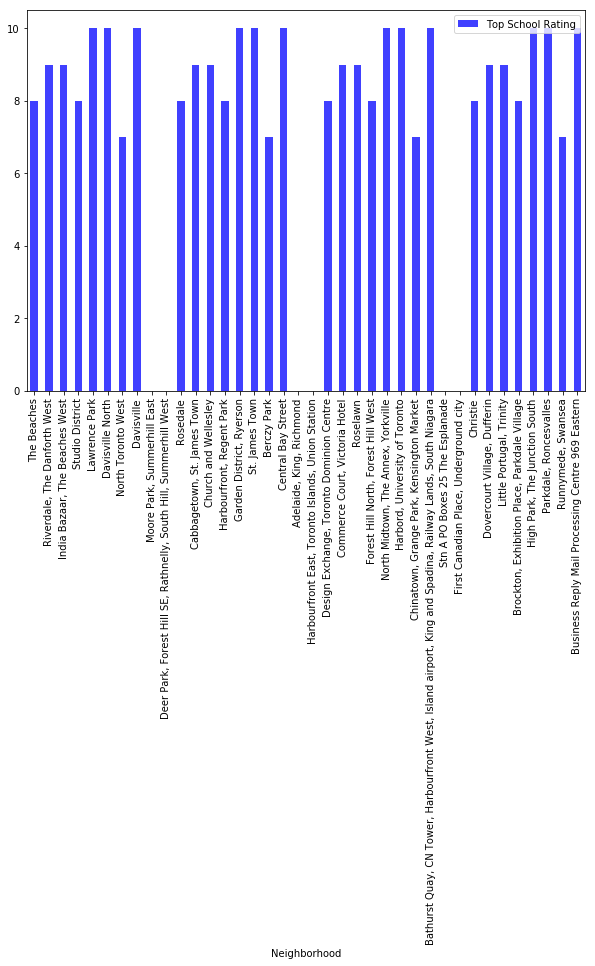

In [18]:
# The code was removed by Watson Studio for sharing.

### Average house price in Neighborhood of Toronto 

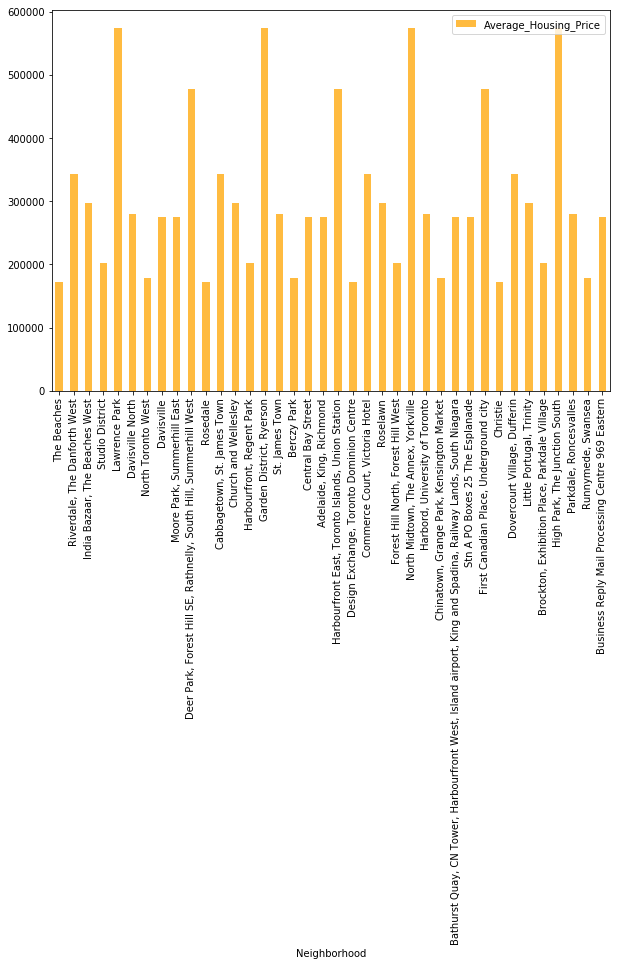

In [8]:
# The code was removed by Watson Studio for sharing.

### Crime rate  in Neighborhood of Toronto 

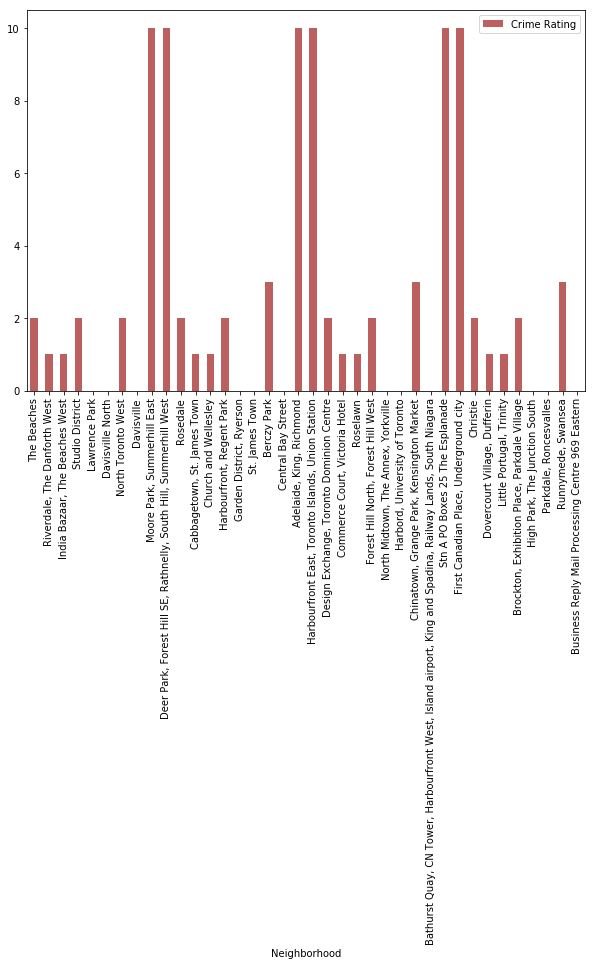

In [9]:
# The code was removed by Watson Studio for sharing.

### Population in Neighborhood of Toronto 

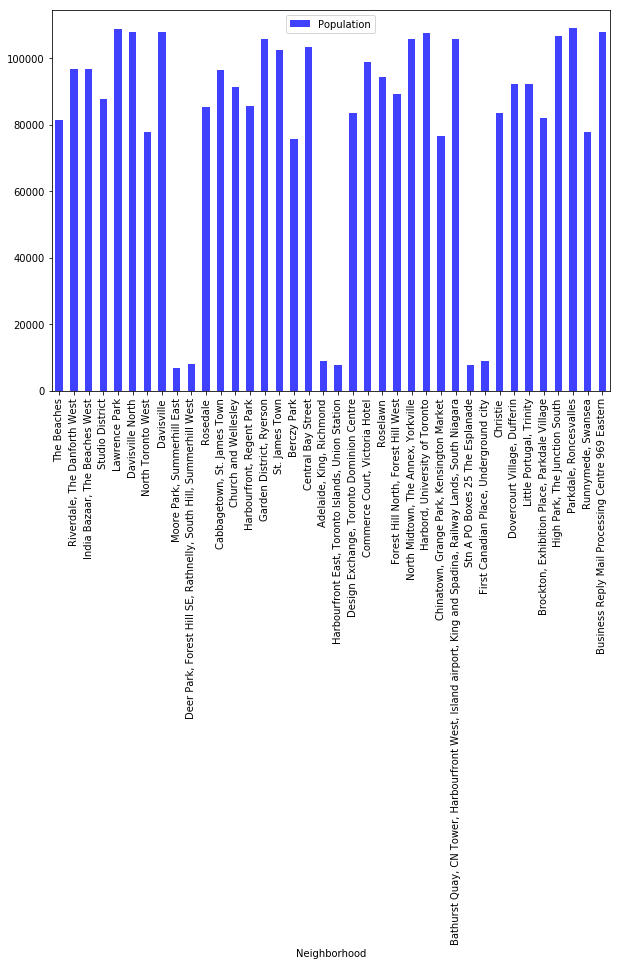

In [10]:
# The code was removed by Watson Studio for sharing.

# Results

### Comparison of 2 Neighborhoods of Toroto.  (Studio District vs Davisville)

### Comparison based on the top 5 common place

In [11]:
# The code was removed by Watson Studio for sharing.

Neighborhood,Studio District,Davisville
PostalCode,M4M,M4S
Borough,East Toronto,Central Toronto
Postal Code,M4M,M4S
Latitude,43.6595255,43.7043244
Longitude,-79.340923,-79.3887901
Cluster Labels,0,0
1st Most Common Venue,Café,Sandwich Place
2nd Most Common Venue,Coffee Shop,Dessert Shop
3rd Most Common Venue,Bakery,Pizza Place
4th Most Common Venue,Italian Restaurant,Café


### Comparison based on population

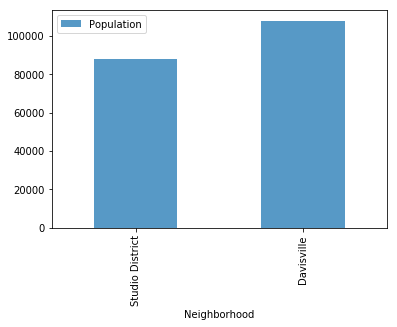

In [12]:
# The code was removed by Watson Studio for sharing.

In [13]:
# The code was removed by Watson Studio for sharing.

,Population
Neighborhood,
Studio District,87767
Davisville,107878


### Comparison based on School Ratings

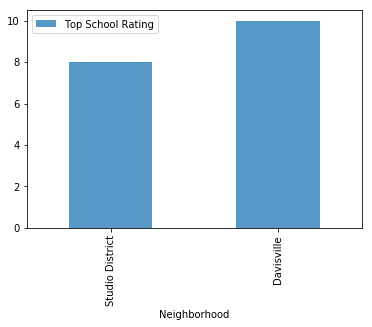

In [14]:
# The code was removed by Watson Studio for sharing.

In [15]:
# The code was removed by Watson Studio for sharing.

,Top School Rating
Neighborhood,
Studio District,8
Davisville,10


### Comparison  based on average house price

,Average_Housing_Price
Neighborhood,
Studio District,202000.0
Davisville,275000.0


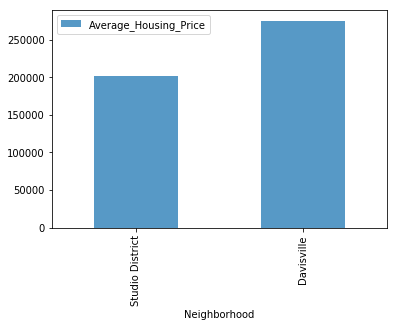

In [16]:
# The code was removed by Watson Studio for sharing.

### Comparison based on crime rate

,Crime Rating
Neighborhood,
Studio District,2
Davisville,0


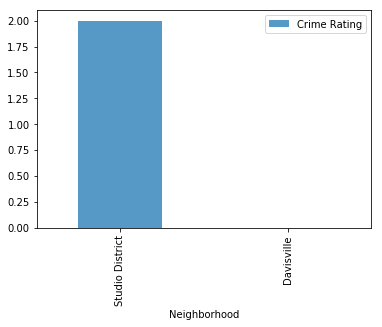

In [17]:
# The code was removed by Watson Studio for sharing.

 # Discussion

Compared to Studio District, Davisville has the higher number of population ,good school rating , less crime rate and a reasonable avg housing price ,also top 5 common venues shows Davisville has gotton a good neighborhood.
In future the analysis can be generalized to 
1) both residential and commercial space 
2) add more factors like job/study location 

 and a neighbourhood prediction engine can be modelled using clustering and segmentation for reliable prediction results.


# Conclusion

This Analysis concludes  Davisville is a better locality to buy/rent a house based of factors like population, school rating, crime rate , top common venues and average house price.